<a href="https://colab.research.google.com/github/Frodo-Swaggins/COMP702PROJECT/blob/main/comp703project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

START OF PREPROCESSING

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#imports and creating the path to the images
import os
import cv2
cv2.__version__
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from scipy.stats import skew
from scipy.stats import entropy as en
from skimage.morphology import disk

mypath = '/content/drive/MyDrive/RandNotes'

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

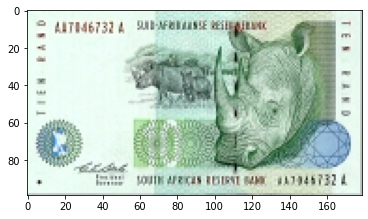

In [4]:
#Opening the images and loading them as image objects into an array using open cv
images = []
count = 0

for fil in onlyfiles:
  imagepath = '/content/drive/MyDrive/RandNotes/' + fil
  image = cv2.imread(imagepath)
  images.append(image)

plt.imshow(images[0])

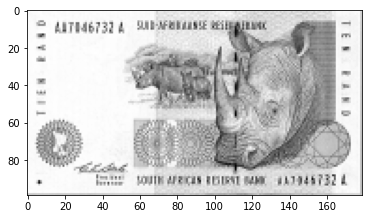

In [6]:
#grayscale conversion on the array of images
grays = []
for image in images:
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  grays.append(gray)
plt.imshow(grays[0], cmap = 'gray')

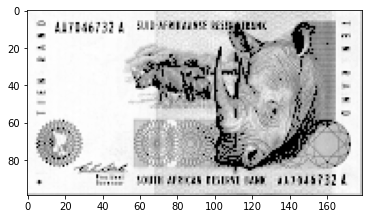

In [7]:
#Thresholding of the array of images
binary = []
for gray in grays:
  blurred = cv2.GaussianBlur(gray, (7, 7), 0)
  ret, thresh1 = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)
  ret, thresh2 = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)
  ret, thresh3 = cv2.threshold(gray, 120, 255, cv2.THRESH_TRUNC)
  ret, thresh4 = cv2.threshold(gray, 120, 255, cv2.THRESH_TOZERO)
  ret, thresh5 = cv2.threshold(gray, 120, 255, cv2.THRESH_TOZERO_INV)
  ret, thresh6 = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  adaptiveThresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 10)
 
  binary.append(thresh4)
plt.imshow(binary[0], cmap = 'gray')

In [8]:
#Histogram normalisation of the therholded array of images
equ = []

for bin in binary:
  equalised = cv2.equalizeHist(bin)
  equ.append(equalised)

plt.imshow(equ[0], cmap = 'gray')

In [10]:
#Data augmentation is performed on the equalised images
#We take the first half (0-25) of the images and rotate them 90 degrees clockwise
#We take the second half (26-49) of the images and rotate them 90 degrees counterclockwise
#We do this to increase the size of our dataset
preprocessed = []
for i in range (len(equ)):
  if(i<=25):
    preprocessed.append(equ[i])
    preprocessed.append(cv2.rotate(equ[i],cv2.cv2.ROTATE_90_CLOCKWISE))
  if(i<=49 and i>25):
    preprocessed.append(equ[i])
    preprocessed.append(cv2.rotate(equ[i],cv2.cv2.ROTATE_90_COUNTERCLOCKWISE))
#plt.imshow(preprocessed[1], cmap = 'gray')
#print(len(preprocessed))

END OF PREPROCESSING

ENHANCEMENT

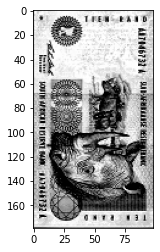

In [11]:
#Enhancement code
hist=[]
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
for pp in preprocessed:
  hist.append(clahe.apply(pp))

plt.imshow(hist[1], cmap = 'gray')

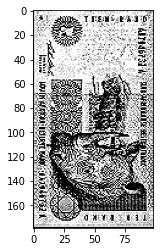

In [12]:
#Sharpening
sharp=[]
for h in hist:
  sharp.append(cv2.filter2D(src=h,ddepth=0,kernel=np.array([[0, -1, 0],[-1, 5,-1],[0, -1, 0]])))

plt.imshow(sharp[1],cmap='gray')

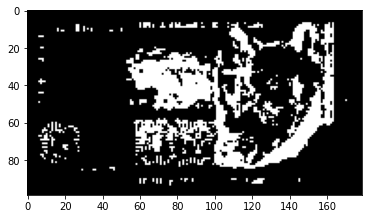

In [13]:
#Segmentation
from scipy import optimize,signal

def adaptive(img , kernel_size, method = "bin_inv"):
    I = img.copy()
    if (kernel_size % 2) == 0:  # check if the size is even
        kernel_size += 1  # if it does -> make odd. by +1 we more % of the signal
    kernel = np.ones((kernel_size, kernel_size)) / (kernel_size**2)
    t = signal.convolve2d(I,kernel, mode='same')
    if method == "bin":
        I[I <= t] = 0
    if method =="bin_inv":
        I[I > t] = 0
    I[I > 0] = 255
    return I

def kernel_Gauss(kernel_size,sigma): #creates gaussian kernel with given size, and std (sigma)
    ax = np.linspace(- (kernel_size-1) / 2,  (kernel_size-1) / 2,  kernel_size)
    x, y = np.meshgrid(ax,ax)
    kernel = (1 / (2 * np.pi * sigma ** 2)) * np.exp(-(np.square(x) + np.square(y)) / (2 * (sigma ** 2)))
    return kernel / kernel.sum()

def adaptiveGauss(img , kernel_size, method = "bin"):
    I = img.copy()
    sigma = 0.3*((kernel_size-1)*0.5 - 1) + 0.8
    if (kernel_size % 2) == 0:  # check if the size is even
        kernel_size += 1  # if it does -> make odd. by +1 we more % of the signal
    kernel = kernel_Gauss(kernel_size,sigma)
    t = signal.convolve2d(I,kernel, mode='same')
    if method == "bin":
        I[I <= t] = 0
    if method =="bin_inv":
        I[I > t] = 0
    I[I > 0] = 255
    return I

segmented = []

for num_of_im in range(1):
    img_samp = sharp[num_of_im]
    img_samp = cv2.GaussianBlur(img_samp ,(3,3),cv2.BORDER_DEFAULT) #apply some smoothing
    thh_inv = adaptive(img_samp , 109)
    thh_inv_g = adaptiveGauss(img_samp,109)
    segmented.append(thh_inv)
    plt.imshow(thh_inv_g,cmap='gray')

plt.imshow(segmented[0],cmap='gray')

https://developpaper.com/simple-implementation-of-region-growing-in-python/ - Source used for segmentation code

In [14]:
# # importing required libraries
# #!pip install mahotas
# import mahotas
# import numpy as np
# from pylab import imshow, show
# import os
 
# # haar transform 
# h = mahotas.haar(sharp[1])
# # showing image
# print("Image with haar transform")
# imshow(h)
# show()



FEATURE EXTRACTION

In [16]:

from scipy.stats.stats import kurtosis
from scipy.ndimage.measurements import variance
import math
from scipy import ndimage
# Hu moment features extracted from segmented images
Hu_moment_features = []
for i in sharp:
  im = i
  # Calculate Moments
  moments = cv2.moments(im)
  # Calculate Hu Moments
  huMoments = cv2.HuMoments(moments)
  # Log scale hu moments
  for i in range(0,7):
    huMoments[i] = -1* math.copysign(1.0, huMoments[i]) * math.log10(abs(huMoments[i]))
  # Append features vector to array of feature vectors
  Hu_moment_features.append(huMoments)

#print((Hu_moment_features[0]))
#print(ndimage.variance(sharp[0]))

# variance_array = []
# for i in sharp:
#   variance_array.append(np.var(i))
# print('variance ',variance_array[0])

# skewness_array = []
# for i in sharp:
#   skewness_array.append(skew(np.array(i).flatten()))
# print('skewness ',skewness_array[0])

# kurtosis_array = []
# for i in sharp:
#   kurtosis_array.append(kurtosis(np.array(i).flatten()))
# print('kurtosis ',kurtosis_array[0])

# entropy_array = []
# for i in sharp:
#   pd_series = pd.Series(np.array(i).flatten())
#   counts = pd_series.value_counts()
#   #entropy_array.append(e(counts))
# #print(entropy_array[0])

# a = [1,2,2,3,3,3]

# pd_series = pd.Series(a)
# a = pd.Series(a)
# print(en(a.value_counts()))
# a = np.array(a)
# data = np.unique(a,return_counts=True)
# print(en(a))
# normalized_dependency_matrix = []
# normalized_dependency_matrices = []
# for i in sharp:
#   R = i.sum()
#   for j in range(len(i)):
#     for k in range(len(i[j])):
#         normalized_dependency_matrix.append((i[j][k])/R)
#   normalized_dependency_matrices.append(normalized_dependency_matrix)
#   normalized_dependency_matrix = []

# Haralick feature extraction
haralick_features = []
!pip install mahotas
import mahotas as mt
for i in sharp:
  texture = mt.features.haralick(i)
  ht_mean = texture.mean(axis=0)
  haralick_features.append(ht_mean)

haralick_features[0]

     |████████████████████████████████| 5.7 MB 26.1 MB/s 


array([ 3.05675771e-02,  1.63101485e+04,  2.64339321e-01,  1.10851184e+04,
        2.18419349e-01,  3.08942939e+02,  2.80303251e+04,  7.24898747e+00,
        9.22031170e+00,  2.35357372e-04,  6.31642084e+00, -1.51143421e-01,
        8.82311861e-01])

Training

In [18]:
# We have two types of features vectors to work with
import numpy as np
import pandas as pd
#Hu
arr1 = np.array(Hu_moment_features)
x,y,z = arr1.shape
arr1 = arr1.reshape(x,y)
print(arr1[0])
banknotes = pd.DataFrame(arr1, columns = ['1','2','3','4','5','6','7'])
banknotes.head()
#Haralick
arr2 = np.array(haralick_features)
x,y = arr2.shape
arr2 = arr2.reshape(x,y)
banknotes2 = pd.DataFrame(arr2, columns = ['1','2','3','4','5','6','7','8','9','10','11','12','13'])
banknotes2.head()

[  2.8694207    6.27369003  10.16016277  10.00223969  20.0834554
  13.13984129 -22.17145017]


,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.030568,16310.148453,0.264339,11085.118391,0.218419,308.942939,28030.325112,7.248987,9.220312,0.000235,6.316421,-0.151143,0.882312
1,0.031085,16389.093723,0.262078,11104.630910,0.219568,309.934336,28029.429917,7.225270,9.194772,0.000239,6.295403,-0.149961,0.880184
2,0.012015,10134.671638,0.473020,9615.017923,0.169905,302.901052,28325.400054,8.110104,11.101872,0.000107,6.848808,-0.183796,0.945294
3,0.010652,10095.229707,0.469907,9521.366340,0.161828,301.093175,27990.235653,8.166319,11.232725,0.000097,6.893382,-0.182867,0.946077
4,0.029194,16790.193596,0.271794,11528.025144,0.217119,293.393939,29321.906978,7.254133,9.286792,0.000240,6.282333,-0.151274,0.883684
